### Example from o1-preview:
Modified to match the packages that is installed in the decifer_env

In [1]:
from pymatgen.io.cif import CifParser
parser_from_string = CifParser.from_str
from dscribe.descriptors import SOAP
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from ase.io import read

from scipy.spatial.distance import pdist, squareform

# Find cifs:
cifs = glob("../data/chili100k/raw/*.cif")

# Because we have paths, we use this
structure1 = CifParser(cifs[0]).parse_structures()[0].to_ase_atoms()
structure2 = CifParser(cifs[1]).parse_structures()[0].to_ase_atoms()

# If we had strings, we would use this
# structure1 = parser_from_string(cifs[0]).get_structures()[0].to_ase_atoms()
# structure2 = parser_from_string(cifs[1]).get_structures()[0].to_ase_atoms()

# Get the unique atomic numbers (species)
species = sorted(set(structure1.get_atomic_numbers()).union(structure2.get_atomic_numbers()))

# Initialize the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=True,
    r_cut=3.25,
    n_max=12,
    l_max=12,
    sigma=0.5,
    sparse=False,
    average="inner",
)

soap_structure_1 = soap.create(structure1)
soap_structure_2 = soap.create(structure2)

soap_structures = np.vstack([soap_structure_1, soap_structure_2])
distance_matrix = squareform(pdist(soap_structures))
print("Distance matrix: structure1 - structure2: ")
print(distance_matrix)

Distance matrix: structure1 - structure2: 
[[ 0.         16.87733263]
 [16.87733263  0.        ]]


/home/dev/miniconda3/envs/decifer_env/lib/python3.9/site-packages/pymatgen/io/cif.py:1259: UserWarning: The default value of primitive was changed from True to False in https://github.com/materialsproject/pymatgen/pull/3419. CifParser now returns the cell in the CIF file as is. If you want the primitive cell, please set primitive=True explicitly.
  warnings.warn(


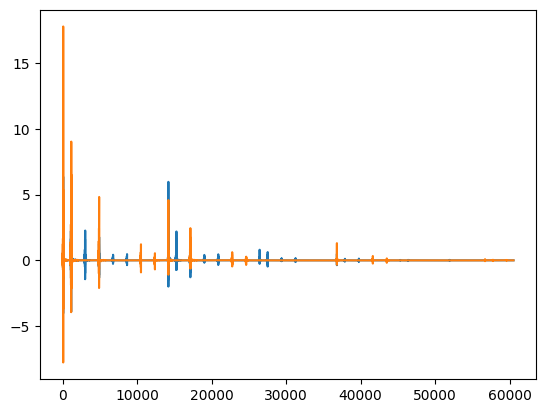

In [2]:
plt.plot(soap_structure_1)
plt.plot(soap_structure_2)

In [3]:
import warnings
warnings.filterwarnings("ignore")
from tqdm.cli import tqdm

import random

cif_files_a = cifs[:200] # ["dataset_a_struct1.cif", "dataset_a_struct2.cif", ...]
cif_files_b = cifs[:200] # ["dataset_b_struct1.cif", "dataset_b_struct2.cif", ...]
random.shuffle(cif_files_a)
random.shuffle(cif_files_b)

# Ensure both datasets have the same length
assert len(cif_files_a) == len(cif_files_b), "Datasets must have the same number of structures."

# Parse structures from both datasets
structures_a = []
structures_b = []
pbar = tqdm(total = len(cif_files_a), desc='Parsing structures')
for cif_a, cif_b in zip(cif_files_a, cif_files_b):
    try:
        struc1 = read(cif_a)
        struc2 = read(cif_b)
        structures_a.append(struc1)
        structures_b.append(struc2)
    except:
        pbar.update(1)
        continue
    pbar.update(1)
pbar.close()

structures = structures_a + structures_b

# Update the species list
species_set = set()
pbar = tqdm(total = len(structures), desc='Updating species list')
for struct in structures:
    species_set.update(struct.get_atomic_numbers())
    pbar.update(1)
pbar.close()
species = sorted(species_set)

# Re-initialize the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=True,
    r_cut=3.25,
    n_max=12,
    l_max=12,
    sigma=0.5,
    sparse=False,
    average="inner"
)

Updating species list: 100%|██████████████████████████████████████████████████████| 400/400 [00:00<00:00, 130166.93it/s]


In [4]:
# Compute distances between corresponding pairs
distances = []
pbar = tqdm(total = len(structures_a), desc='Calculating distances')
for struct_a, struct_b in zip(structures_a, structures_b):

    soap_a = soap.create(struct_a)
    soap_b = soap.create(struct_b)
    distances.append(np.dot(soap_a, soap_b) / np.sqrt(np.dot(soap_a, soap_a) * np.dot(soap_b, soap_b)))
    # distances.append(np.linalg.norm(soap_a - soap_b))
    pbar.update(1)
pbar.close()

# Calculate statistics
mean_distance = np.mean(distances)
std_distance = np.std(distances)

print(f"Mean distance between corresponding structures: {mean_distance:.4f}")
print(f"Standard deviation: {std_distance:.4f}")

Calculating distances: 100%|██████████████████████████████████████████████████████████| 200/200 [00:35<00:00,  5.61it/s]

Mean distance between corresponding structures: 0.1831
Standard deviation: 0.2954


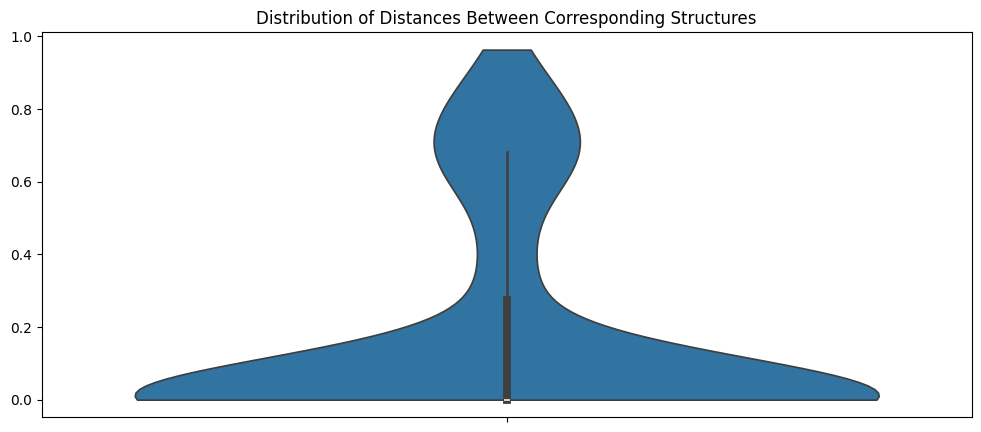

In [5]:
import seaborn as sns
import pandas as pd

# Plot histogram
fig, ax = plt.subplots(figsize=(12, 5))
# ax.violinplot(distances, bins=50, edgecolor='black')
sns.violinplot(data=distances, cut=0, ax=ax)
# ax.set_xlabel("Euclidean Distance")
# ax.set_ylabel("Frequency")
ax.set_title("Distribution of Distances Between Corresponding Structures")
# ax.axvline(np.mean(distances), color='red', linestyle='dashed', linewidth=1, label=f'Mean = {np.mean(distances):.2f}')
# ax.axvline(np.median(distances), color='green', linestyle='dashed', linewidth=1, label=f'Median = {np.median(distances):.2f}')
# ax.set_yscale('log')
plt.show()

In [6]:
soap_b.shape

(5270850,)

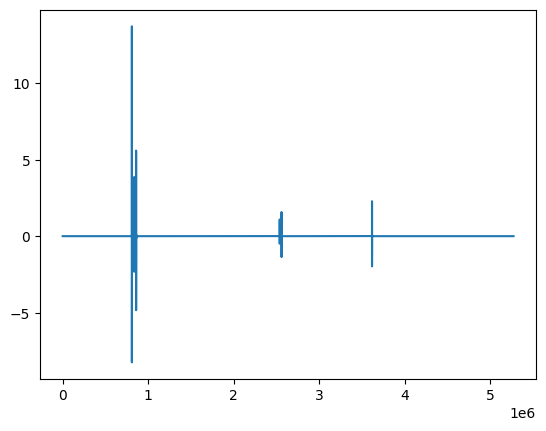

In [7]:
plt.plot(soap_a)

In [8]:
import pandas as pd

In [9]:
pd.read_parquet("../testing_refactored/test_name.eval")

,status,index,rep,cif_gen,spacegroup,species,dataset_name,model_name,seq_len,cif_sample,...,descriptors.xrd_dirty_from_sample.q,descriptors.xrd_dirty_from_sample.iq,descriptors.soap_gen,descriptors.soap_sample,composition.Ni,composition.Pb,composition.S,composition.Tl,composition.Mg,composition.Ti
0,fail,5,0,None,None,None,None,None,NaN,None,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN
1,fail,9,0,None,None,None,None,None,NaN,None,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN
2,success,7,0,data_Nd8In4Hg4\nloop_\n_atom_type_symbol\n_ato...,Fm-3m,"[In, Nd, Hg]",test_name,default_model,328.0,# generated using pymatgen\ndata_Nd2InHg\nloop...,...,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[5.2649457e-06, 5.3087924e-06, 5.353228e-06, 5...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,NaN,NaN,NaN,NaN
3,success,3,0,data_Ni9Pb6S6\nloop_\n_atom_type_symbol\n_atom...,Imm2,"[Pb, S, Ni]",test_name,default_model,436.0,# generated using pymatgen\ndata_Ni3(PbS)2\nlo...,...,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[1.9729358e-05, 1.9920084e-05, 2.0113892e-05, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9.0,6.0,7.0,NaN,NaN,NaN
4,success,6,0,data_Tl2Hg4Bi2\nloop_\n_atom_type_symbol\n_ato...,P-62m,"[Tl, S, Hg]",test_name,default_model,330.0,# generated using pymatgen\ndata_TlHg2Bi\nloop...,...,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[7.1671857e-06, 7.2242974e-06, 7.282121e-06, 7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,4.0,2.0,NaN,NaN
5,fail,4,0,None,None,None,None,None,NaN,None,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN
6,fail,0,0,None,None,None,None,None,NaN,None,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN
7,fail,8,0,None,None,None,None,None,NaN,None,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN
8,fail,2,0,None,None,None,None,None,NaN,None,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN
9,success,1,0,data_Mg4Ti8\nloop_\n_atom_type_symbol\n_atom_t...,P6_3/mmc,"[Mg, Ti]",test_name,default_model,299.0,# generated using pymatgen\ndata_MgTi2\nloop_\...,...,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[1.5915199e-05, 1.6136415e-05, 1.6364049e-05, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,NaN,NaN,NaN,4.0,6.0


7188.111597208287


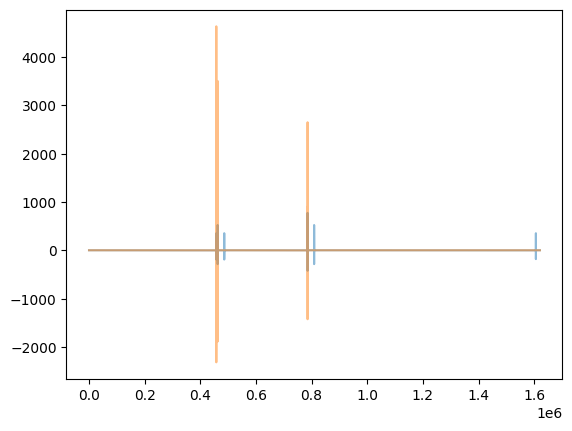

In [10]:
gen_soap = pd.read_parquet("../testing_refactored/test_name.eval")['descriptors.soap_gen'][3]
sample_soap = pd.read_parquet("../testing_refactored/test_name.eval")['descriptors.soap_sample'][3]
plt.plot(sample_soap, alpha=0.5)
plt.plot(gen_soap, alpha=0.5)
print(np.linalg.norm(sample_soap - gen_soap))